In [1]:
# Importing the libraries required for data pre-processing and model development
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

from collections import Counter
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, learning_curve


from sklearn.gaussian_process.kernels import DotProduct, RBF, Matern

%matplotlib inline
pd.set_option('max_columns', None)
sns.set(style='white', context='notebook', palette='deep')

## Data  Processing

In [2]:
# importing the dataset
train= pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
passengerID=test["PassengerId"]
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Calculating the total number of null values
train= train.fillna(np.nan)
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

(5.0, 0.0)

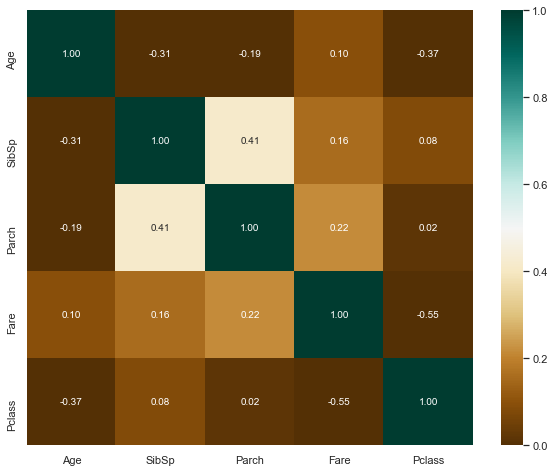

In [4]:
# Finding which datapoints predict age best
corr= train[["Age","SibSp","Parch","Fare", "Sex", "Pclass"]].corr()
plt.figure(figsize=(10,8))
g=sns.heatmap(corr, annot=True, cmap="BrBG", fmt= "0.2f", vmin=0, vmax=1)
bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)

C:\Users\abhin\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\abhin\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\abhin\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.wa

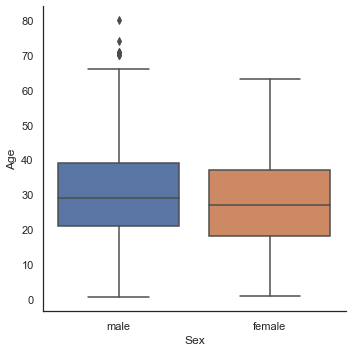

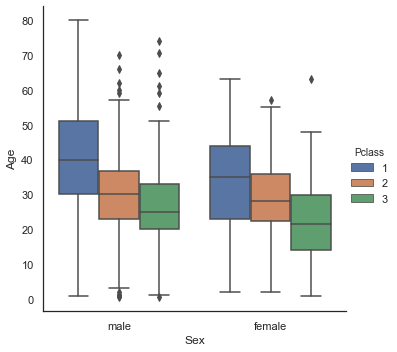

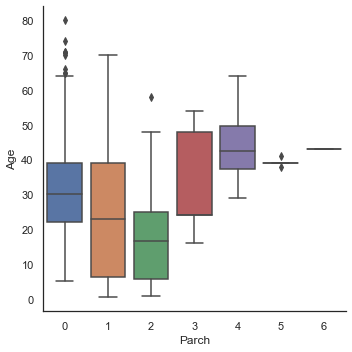

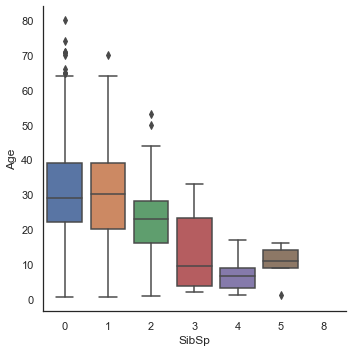

In [5]:
# Visualising the age vs rest of the parameters
g = sns.factorplot(y="Age",x="Sex",data=train,kind="box")
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=train,kind="box")
g = sns.factorplot(y="Age",x="Parch", data=train,kind="box")
g = sns.factorplot(y="Age",x="SibSp", data=train,kind="box")

In [6]:
# Replacing the null values present in age on basis of Pclass
index_NaN_age = list(train["Age"][train["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = train["Age"].median()
    age_pred = train["Age"][(train['Pclass'] == train.iloc[i]["Pclass"])].median()
    if not np.isnan(age_pred) :
        train['Age'].iloc[i] = age_pred
    else :
        train['Age'].iloc[i] = age_med

C:\Users\abhin\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
# Counting total number of sub-classespresent in embarked
train.groupby("Embarked").count()["PassengerId"]

Embarked
C    168
Q     77
S    644
Name: PassengerId, dtype: int64

In [8]:
#  Replacing the null values present Embarked with S as it has the highest count
train["Embarked"]= train["Embarked"].replace(np.nan, "S")

In [9]:
# Detecting the outliers present in train dataset
def outlier_detection(df,n, features):
    outliers=[]
    for col in features:
        q1= np.percentile(df[col], 25)
        q3= np.percentile(df[col], 75)
        iqr= q3-q1
        outlier_step= iqr* 1.5
        outliers_col= df[(df[col]< q1-outlier_step) | ( df[col]> q3+outlier_step)].index
        outliers.extend(outliers_col)
        
    outliers= Counter(outliers)
    true_outliers= list(k for k,v in outliers.items() if v>n)
    return true_outliers

true_outliers= outlier_detection(train,2, ["Age","SibSp","Parch","Fare"])
train.loc[true_outliers]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
438,439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.00,C23 C25 C27,S
587,588,1,1,"Frolicher-Stehli, Mr. Maxmillian",male,60.0,1,1,13567,79.20,B41,C
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.00,B22,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,24.0,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,24.0,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,24.0,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,24.0,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S


In [10]:
# Dropping the outliers
train.drop(true_outliers, axis=0, inplace=True)

In [11]:
# Counting null values in dataset
test= test.fillna(np.nan)
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [12]:
# Replacing the null values present in age on basis of Pclass
index_NaN_age = list(test["Age"][test["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = test["Age"].median()
    age_pred = test["Age"][(test['Pclass'] == test.iloc[i]["Pclass"])].median()
    if not np.isnan(age_pred) :
        test['Age'].iloc[i] = age_pred
    else :
        test['Age'].iloc[i] = age_med

In [13]:
# Replacing null value with median of Fare
test["Fare"]= test["Fare"].replace(np.nan, test["Fare"].median())

In [14]:
# Concatanating the train and test dataset together
train_len= len(train)
data= pd.concat([train, test], axis=0).reset_index(drop=True)
data= data.fillna(np.nan)
data

C:\Users\abhin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
...,...,...,...,...,...,...,...,...,...,...,...,...
1291,24.0,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236
1292,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758
1293,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262
1294,24.0,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309


## Data Visualisation

<Figure size 864x432 with 0 Axes>

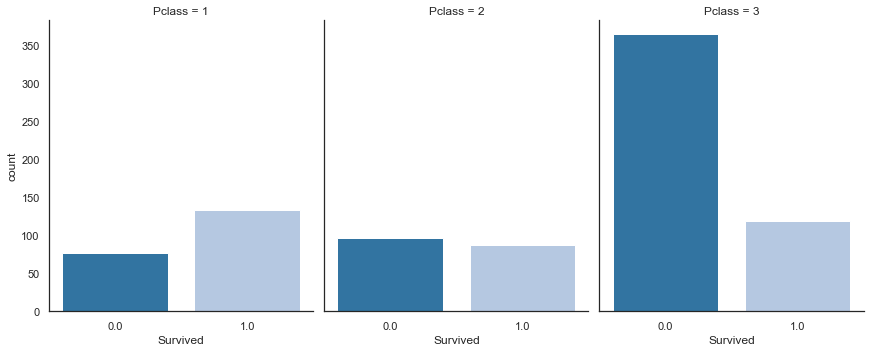

In [15]:
fig = plt.figure(figsize = (12, 6))
ax = sns.catplot("Survived", 
                 col = "Pclass", 
                 data = data, 
                 kind = "count",  
                 palette = 'tab20',  
                 aspect = .8
                );

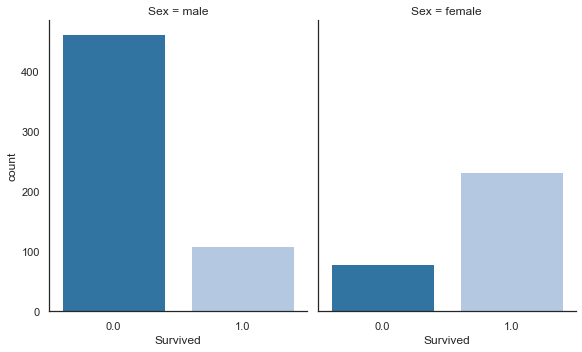

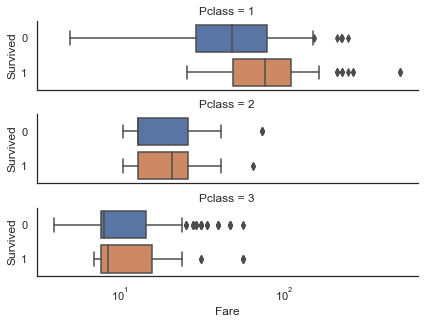

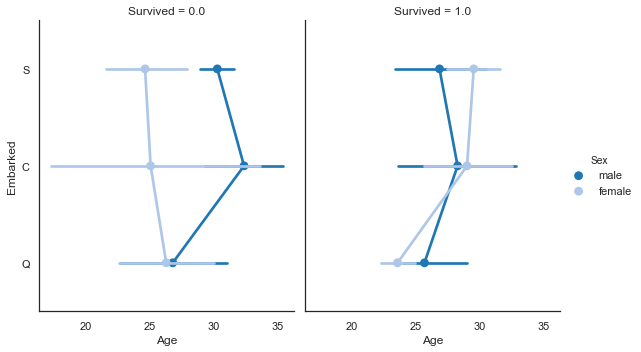

In [16]:
ax = sns.catplot("Survived", 
                 col = "Sex", 
                 data = data, 
                 kind = "count",  
                 palette = 'tab20',  
                 aspect = .8
                )
g = sns.catplot(x="Fare", y="Survived", row="Pclass",
                kind="box", orient='h', height=1.5, aspect=4,
                data=train.query("Fare > 0"))
g.set(xscale="log")
ax = sns.catplot(x = "Age",
                 y = "Embarked",
                 col = "Survived",
                 hue = "Sex",
                 data = data, 
                 kind = "point",  
                 palette = 'tab20',  
                 aspect = .8
                )

## Feature Engineering and Mapping

In [17]:
# Mapping gender to 0 & 1
data["Sex"]= data["Sex"].map({'male':0 , 'female': 1})

In [18]:
# Creating a new feature title from name
data["Title"] = data["Name"].str.split(",", expand= True)[1].str.split(".",expand=True)[0].str.strip()
data["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

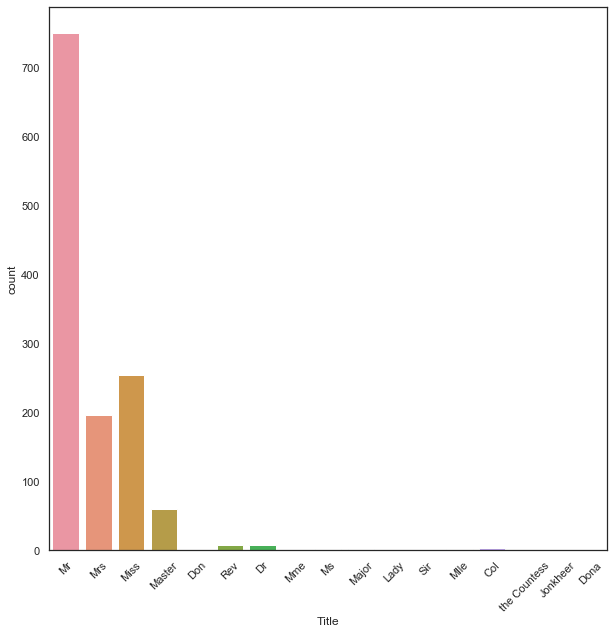

In [19]:
plt.figure(figsize=(10,10))
g= sns.countplot(x="Title", data= data)
g = plt.setp(g.get_xticklabels(), rotation=45)

In [20]:
data["Title"] = data["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
data["Title"] = data["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
data["Title"] = data["Title"].astype(int)

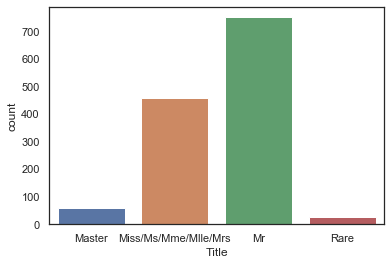

In [21]:
g = sns.countplot(data["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

In [22]:
# Creating new feature Family size to predict what size of family has more chance of survival
data["Fsize"]= data["Parch"] +data["SibSp"]+1


data["Single"] = data['Fsize'].map(lambda s: 1 if s == 1 else 0)
data["SmallF"] = data['Fsize'].map(lambda s: 1 if s == 2 else 0)
data["MedF"] = data['Fsize'].map(lambda s: 1 if 3 >=s<=5 else 0)
data["LargeF"] = data['Fsize'].map(lambda s: 1 if s >5 else 0)

C:\Users\abhin\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


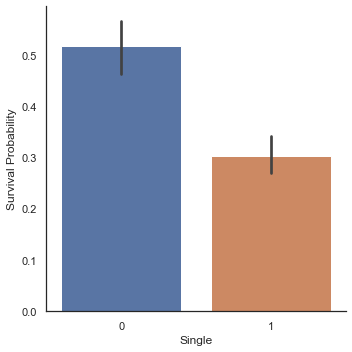

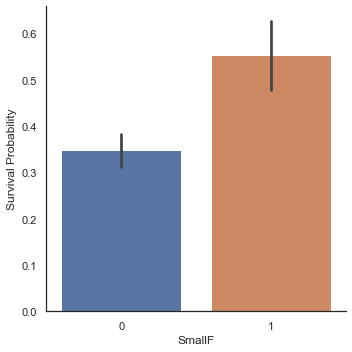

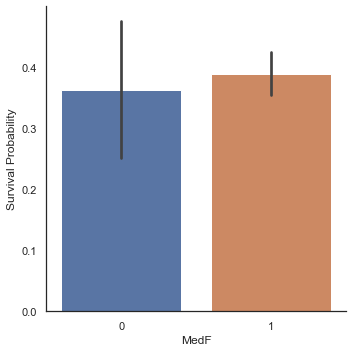

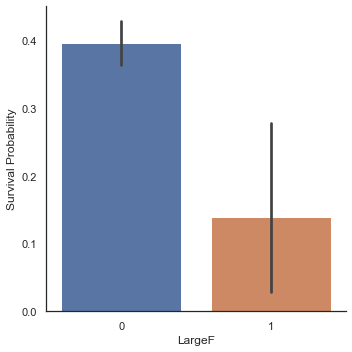

In [23]:
# PLotting to see what size of family has more chance of survival
g = sns.factorplot(x="Single",y="Survived",data=data,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="SmallF",y="Survived",data=data,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="MedF",y="Survived",data=data,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="LargeF",y="Survived",data=data,kind="bar")
g = g.set_ylabels("Survival Probability")

In [24]:
# Creating new feature from age to see which generation has more chance of survival
data["Child"]= data['Age'].map(lambda s: 1 if s <15  else 0)
data["Young"]= data['Age'].map(lambda s: 1 if 15<= s <50  else 0)
data["Old"]= data['Age'].map(lambda s: 1 if s>=50  else 0)

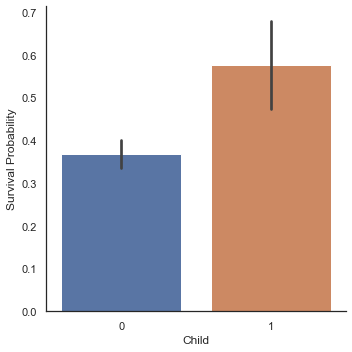

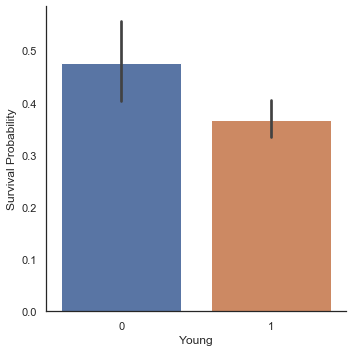

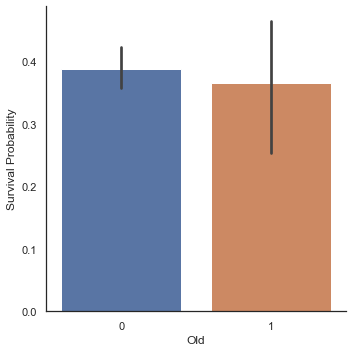

In [25]:
# Plotting to see which generation has more chance of survival
g = sns.factorplot(x="Child",y="Survived",data=data,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="Young",y="Survived",data=data,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="Old",y="Survived",data=data,kind="bar")
g = g.set_ylabels("Survival Probability")

In [26]:
data.isnull().sum()

Age               0
Cabin          1007
Embarked          0
Fare              0
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
Title             0
Fsize             0
Single            0
SmallF            0
MedF              0
LargeF            0
Child             0
Young             0
Old               0
dtype: int64

In [27]:
data["Cabin"][data["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [28]:
# Extracting the first letter from cabin and mapping all the null value with X
data["Cabin"] = pd.Series([x[0]  if not pd.isnull(x) else "X" for x in data["Cabin"]])

In [29]:
# Normalising The fare
data["Fare"]= (data["Fare"]- data["Fare"].min())/ (data["Fare"].max()- data["Fare"].min())

In [30]:
# Creating dummy values for all the lsited features
data = pd.get_dummies(data, columns = ["Embarked", "Pclass", "Title", "Cabin"],prefix=["Em", "Pclass", "Title", "Cabin"])
data.head()

,Age,Fare,Name,Parch,PassengerId,Sex,SibSp,Survived,Ticket,Fsize,Single,SmallF,MedF,LargeF,Child,Young,Old,Em_C,Em_Q,Em_S,Pclass_1,Pclass_2,Pclass_3,Title_0,Title_1,Title_2,Title_3,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X
0,22.0,0.014151,"Braund, Mr. Owen Harris",0,1,0,1,0.0,A/5 21171,2,0,1,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1
1,38.0,0.139136,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1.0,PC 17599,2,0,1,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,26.0,0.015469,"Heikkinen, Miss. Laina",0,3,1,0,1.0,STON/O2. 3101282,1,1,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
3,35.0,0.103644,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1.0,113803,2,0,1,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
4,35.0,0.015713,"Allen, Mr. William Henry",0,5,0,0,0.0,373450,1,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1


In [31]:
# Dropping all the unnecessary features
data.drop(["Age", "Name", "Parch", "PassengerId", "SibSp", "Ticket", "Fsize"], axis=1, inplace=True)

## Model Selection and Development

In [32]:
# Splitting data in train and test
train= data[:train_len]
test= data[train_len:]
test.drop("Survived", axis=1, inplace= True)
y_train= train["Survived"]
x_train= train.drop("Survived", axis=1)

C:\Users\abhin\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### Classifiers used:

AdaBoostClassifier  
BaggingClassifier  
BernoulliNB  
DecisionTreeClassifier  
ExtraTreeClassifier  
GaussianProcessClassifier  
GradientBoostingClassifier  
LogisticRegression  
MLPClassifier  
SVC  
RandomForestClassifier  
SGDClassifier  
QuadraticDiscriminantAnalysis  
NuSVC  
LinearDiscriminantAnalysis  

In [33]:
# Using all the classifiers to compare all the classifiers prediction by mean of accuracy
k_fold= StratifiedKFold(n_splits=10)
random_state=2

classifiers=[]
classifiers.append(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=random_state), n_estimators=100, random_state=random_state))
classifiers.append(BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=random_state), n_estimators=20, random_state=random_state))
classifiers.append(BernoulliNB())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(ExtraTreeClassifier(random_state=random_state))
classifiers.append(GaussianProcessClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state, max_iter=400))
classifiers.append(SVC(random_state=random_state))
classifiers.append(RandomForestClassifier(n_estimators=200, random_state=random_state))
classifiers.append(SGDClassifier(max_iter=2000, random_state=random_state))
classifiers.append(QuadraticDiscriminantAnalysis())
classifiers.append(NuSVC(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_score= []
for classifier in classifiers:
    cv_score.append(cross_val_score(classifier, x_train, y=y_train, scoring = "accuracy", cv= k_fold, n_jobs=6))
# print(cv_score) 
cv_means= []
cv_std=  []
for score in cv_score:
    cv_means.append(score.mean())
    cv_std.append(score.std())
# print(len(cv_means)) 
# print(len(cv_std))
cv_result= pd.DataFrame({"CrossValMeans": cv_means , "CrossValStd" : cv_std, "Algorithm": ["AdaBoostClassifier", "BaggingClassifier", "BernoulliNB", "DecisionTreeClassifier", "ExtraTreeClassifier", "GaussianProcessClassifier", "GradientBoostingClassifier", "LogisticRegression", "MLPClassifier", "SVC", "RandomForestClassifier", "SGDClassifier", "QuadraticDiscriminantAnalysis", "NuSVC", "LinearDiscriminantAnalysis"]})

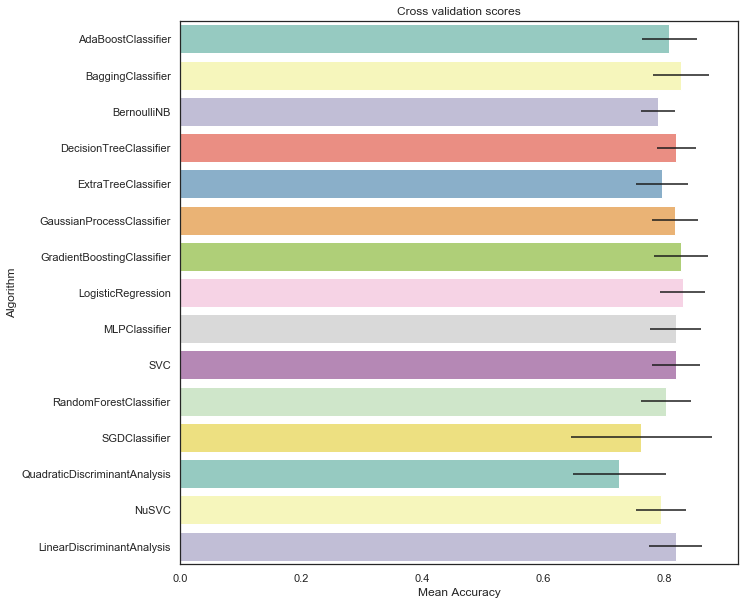

In [34]:
# Plotting to compare results between multipe classifiers
plt.figure(figsize=(10,10))
g = sns.barplot("CrossValMeans","Algorithm",data = cv_result, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")


#### After comparing all the scores, I decided to choose the following classifiers
AdaBoostClassifier  
BaggingClassifier  
DecisionTreeClassifier  
GaussianProcessClassifier  
GradientBoostingClassifier  
LogisticRegression  
MLPClassifier  
SVC  
RandomForestClassifier  
LinearDiscriminantAnalysis  

In [35]:
#To store accuracy given by best estimators
best_scores=[]

#### Model Traing using GridSearchCV to find the best parameters

In [36]:
# AdaBoostClassifier

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[50, 100, 200],
              "learning_rate":  [0.0001, 0.003, 0.01, 0.1, 0.5, 1,1.5]}
gsAda= GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=7), param_grid=ada_param_grid, scoring="accuracy", n_jobs=6, cv=k_fold, verbose=1)

gsAda.fit(x_train, y_train)
best_Ada = gsAda.best_estimator_

Fitting 10 folds for each of 168 candidates, totalling 1680 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  59 tasks      | elapsed:    4.8s
[Parallel(n_jobs=6)]: Done 213 tasks      | elapsed:   15.7s
[Parallel(n_jobs=6)]: Done 463 tasks      | elapsed:   29.4s
[Parallel(n_jobs=6)]: Done 813 tasks      | elapsed:   52.8s
[Parallel(n_jobs=6)]: Done 1263 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 1680 out of 1680 | elapsed:  1.7min finished


In [37]:
best_scores.append(gsAda.best_score_)
gsAda.best_score_

0.8246013667425968

In [38]:
# BaggingClassifier

bagg_param_grid= {"base_estimator__criterion" : ["gini", "entropy"],
                   "base_estimator__splitter" :   ["best", "random"],
                   "n_estimators" :[10,20,50,100],
                  "max_samples" : [0.05, 0.1, 0.2, 0.5],
                   "bootstrap" : [True, False],
                   "bootstrap_features" : [True, False]}

gsBagg= GridSearchCV(BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=7), param_grid=bagg_param_grid, scoring="accuracy" , n_jobs=6, cv=k_fold, verbose=5)
gsBagg.fit(x_train, y_train)

best_Bagg= gsBagg.best_estimator_

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 10 folds for each of 256 candidates, totalling 2560 fits


[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 588 tasks      | elapsed:    7.0s
[Parallel(n_jobs=6)]: Done 1200 tasks      | elapsed:   13.7s
[Parallel(n_jobs=6)]: Done 1956 tasks      | elapsed:   23.8s
[Parallel(n_jobs=6)]: Done 2560 out of 2560 | elapsed:   31.1s finished


In [39]:
best_scores.append(gsBagg.best_score_)
gsBagg.best_score_

0.8382687927107062

In [40]:
# DecisionTreeClassifier

dt_param_grid= {"criterion": ["gini", "entropy"], 
                "splitter": ["best", "random"], 
                "max_depth": np.arange(2, 25), 
                "min_samples_split": np.arange(2,9)}

gsDT= GridSearchCV(DecisionTreeClassifier(random_state=7), param_grid=dt_param_grid, scoring="accuracy" , n_jobs=6, cv=k_fold, verbose=1)
gsDT.fit(x_train, y_train)

best_DT= gsDT.best_estimator_

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 10 folds for each of 644 candidates, totalling 6440 fits


[Parallel(n_jobs=6)]: Done 1000 tasks      | elapsed:    1.0s
[Parallel(n_jobs=6)]: Done 6440 out of 6440 | elapsed:    6.2s finished


In [41]:
best_scores.append(gsDT.best_score_)
gsDT.best_score_

0.837129840546697

In [42]:
# GaussianProcessClassifier


gpc_param_grid= {'kernel':[DotProduct(i) for i in [ 0.5, 1,2,3]] + [Matern(i) for i in [ 0.5, 1,2,3]]  + [RBF(i) for i in [ 0.5, 1,2,3]],
                 "max_iter_predict" : [100, 200,500],
                 "warm_start": [True, False]}
gsGPC= GridSearchCV(GaussianProcessClassifier(random_state=7), param_grid=gpc_param_grid, scoring="accuracy" , n_jobs=6, cv=k_fold, verbose=1)
gsGPC.fit(x_train, y_train)

best_GPC= gsGPC.best_estimator_

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  5.6min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed: 10.7min
[Parallel(n_jobs=6)]: Done 720 out of 720 | elapsed: 16.4min finished


In [43]:
best_scores.append(gsGPC.best_score_)
gsGPC.best_score_

0.8302961275626424

In [44]:
# GradientBoostingClassifier

gbc_param_grid= {"loss" : ["deviance", "exponential"], 
                "learning_rate":  [0.003, 0.01, 0.1, 0.5,1.5],
                "n_estimators" : [100 ,500, 1000],
                "criterion" : ["friedman_mse", "mse", "mae"],
                "max_features": ["sqrt", "log2"],
                'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1]}

gsGBC= GridSearchCV(GradientBoostingClassifier(random_state= 7), param_grid=gbc_param_grid, scoring="accuracy" , n_jobs=6, cv=k_fold, verbose=1)
gsGBC.fit(x_train, y_train)

best_GBC= gsGBC.best_estimator_

Fitting 10 folds for each of 720 candidates, totalling 7200 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 110 tasks      | elapsed:    4.8s
[Parallel(n_jobs=6)]: Done 410 tasks      | elapsed:   19.0s
[Parallel(n_jobs=6)]: Done 910 tasks      | elapsed:   41.6s
[Parallel(n_jobs=6)]: Done 1610 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 2128 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 2678 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 3328 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 4078 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 4928 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 5878 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done 6928 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 7200 out of 7200 | elapsed: 13.9min finished


In [45]:
best_scores.append(gsGBC.best_score_)
gsGBC.best_score_

0.8405466970387244

In [46]:
# LogisticRegression

lr_param_grid= {"C":np.logspace(-3,3,7), 
                "penalty":["l1","l2"],
               "max_iter": [100, 200, 300, 500, 1000, 3000, 5000, 10000]}

gsLR= GridSearchCV(LogisticRegression(random_state= 7), param_grid=lr_param_grid, scoring="accuracy" , n_jobs=6, cv=k_fold, verbose=1)
gsLR.fit(x_train, y_train)

best_LR= gsLR.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 1120 out of 1120 | elapsed:    3.8s finished
C:\Users\abhin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [47]:
best_scores.append(gsLR.best_score_)
gsLR.best_score_

0.8302961275626424

In [48]:
# MLPClassifier

mpl_param_grid = {"hidden_layer_sizes": [(32, 32), (64,64)],
                 "activation": ["logistic", "tanh"],
                 "solver" : ["lbfgs", "sgd"],
                 "alpha": [ 0.003, 0.01, 0.1, 0.5,1.5],
                 "learning_rate_init": [ 0.003, 0.01, 0.1, 0.5,1.5], 
                 "max_iter": [200,500,700],
                 'tol': [ 1e-3, 1e-4, 1e-5],
                  'epsilon': [1e-5, 1e-7, 1e-9]}

gsMPL= GridSearchCV(MLPClassifier(random_state= 7), param_grid=mpl_param_grid, scoring="accuracy" , n_jobs=6, cv=k_fold, verbose=1)
gsMPL.fit(x_train, y_train)

best_MPL= gsMPL.best_estimator_

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 10 folds for each of 5400 candidates, totalling 54000 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.2s
[Parallel(n_jobs=6)]: Done 205 tasks      | elapsed:   22.1s
[Parallel(n_jobs=6)]: Done 455 tasks      | elapsed:   56.7s
[Parallel(n_jobs=6)]: Done 805 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 1255 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 1805 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 2455 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 3205 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 4055 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 5005 tasks      | elapsed: 14.1min
[Parallel(n_jobs=6)]: Done 6055 tasks      | elapsed: 16.7min
[Parallel(n_jobs=6)]: Done 7205 tasks      | elapsed: 20.6min
[Parallel(n_jobs=6)]: Done 8455 tasks      | elapsed: 24.0min
[Parallel(n_jobs=6)]: Done 9805 tasks      | elapsed: 27.5min
[Parallel(n_jobs=6)]: Done 11255 tasks      | elapsed: 32.2min
[Parallel(n_jobs=6)]: Done 12805 tasks      | elapsed: 36.6min
[Parallel(

In [49]:
best_scores.append(gsMPL.best_score_)
gsMPL.best_score_

0.8348519362186788

In [50]:
# SVC
svc_param_grid = {'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000],
                 "probability": [True, False],
                 "shrinking": [True, False]}
gsSVC= GridSearchCV(SVC(random_state= 7), param_grid=svc_param_grid, scoring="accuracy" , n_jobs=6, cv=k_fold, verbose=1)
gsSVC.fit(x_train, y_train)

best_SVC= gsSVC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  39 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done 617 tasks      | elapsed:   11.3s
[Parallel(n_jobs=6)]: Done 1109 out of 1120 | elapsed:   24.2s remaining:    0.1s
[Parallel(n_jobs=6)]: Done 1120 out of 1120 | elapsed:   24.3s finished


In [51]:
best_scores.append(gsSVC.best_score_)
gsSVC.best_score_

0.8291571753986332

In [52]:
# RandomForestClassifier
rf_param_grid = {"max_features": [1, 3, 10],
              "min_samples_split": [2, 3,5, 7, 10, 13, 15],
              "min_samples_leaf": [1,5,7, 3, 10,12, 15],
              "bootstrap": [True, False],
              "n_estimators" :[100,300, 500, 700,1000],
              "criterion": ["gini", "entropy"]}
gsRF= GridSearchCV(RandomForestClassifier(random_state= 7), param_grid=rf_param_grid, scoring="accuracy" , n_jobs=6, cv=k_fold, verbose=1)
gsRF.fit(x_train, y_train)

best_RF= gsRF.best_estimator_

Fitting 10 folds for each of 2940 candidates, totalling 29400 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  54 tasks      | elapsed:    7.0s
[Parallel(n_jobs=6)]: Done 207 tasks      | elapsed:   27.8s
[Parallel(n_jobs=6)]: Done 457 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 807 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 1257 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 1807 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 2457 tasks      | elapsed:  4.5min
[Parallel(n_jobs=6)]: Done 3207 tasks      | elapsed:  6.2min
[Parallel(n_jobs=6)]: Done 4057 tasks      | elapsed:  7.9min
[Parallel(n_jobs=6)]: Done 5007 tasks      | elapsed:  9.8min
[Parallel(n_jobs=6)]: Done 6057 tasks      | elapsed: 12.5min
[Parallel(n_jobs=6)]: Done 7207 tasks      | elapsed: 15.2min
[Parallel(n_jobs=6)]: Done 8457 tasks      | elapsed: 17.7min
[Parallel(n_jobs=6)]: Done 9807 tasks      | elapsed: 20.1min
[Parallel(n_jobs=6)]: Done 11257 tasks      | elapsed: 23.2mi

In [53]:
best_scores.append(gsRF.best_score_)
gsRF.best_score_

0.8405466970387244

In [54]:
# LinearDiscriminantAnalysis
lda_param_grid= { "solver" : ["svd", "lsqr"],
                 "store_covariance": [True, False],
                 "tol": [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]}
gsLDA= GridSearchCV(LinearDiscriminantAnalysis(), param_grid=lda_param_grid, scoring="accuracy" , n_jobs=6, cv=k_fold, verbose=1)
gsLDA.fit(x_train, y_train)

best_LDA= gsLDA.best_estimator_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 200 out of 200 | elapsed:    0.4s finished
C:\Users\abhin\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [55]:
best_scores.append(gsLDA.best_score_)
gsLDA.best_score_

0.8189066059225513

In [56]:
# Storing score of all the classifier to find the best classifiers
best_algo = pd.DataFrame({"Algorithm" : ["AdaBoostClassifier", "BaggingClassifier", "DecisionTreeClassifier", "GaussianProcessClassifier", "GradientBoostingClassifier", "LogisticRegression", "MLPClassifier", "SVC", "RandomForestClassifier", "LinearDiscriminantAnalysis"],
                         "Scores": best_scores, 
                         "Best_Estimators": [best_Ada, best_Bagg, best_DT, best_GPC, best_GBC, best_LR, best_MPL, best_SVC, best_RF, best_LDA]})
best_algo

,Algorithm,Scores,Best_Estimators
0,AdaBoostClassifier,0.824601,"(DecisionTreeClassifier(class_weight=None, cri..."
1,BaggingClassifier,0.838269,"(DecisionTreeClassifier(class_weight=None, cri..."
2,DecisionTreeClassifier,0.837130,"DecisionTreeClassifier(class_weight=None, crit..."
3,GaussianProcessClassifier,0.830296,"GaussianProcessClassifier(copy_X_train=True, k..."
4,GradientBoostingClassifier,0.840547,([DecisionTreeRegressor(criterion='friedman_ms...
5,LogisticRegression,0.830296,"LogisticRegression(C=1.0, class_weight=None, d..."
6,MLPClassifier,0.834852,"MLPClassifier(activation='tanh', alpha=0.5, ba..."
7,SVC,0.829157,"SVC(C=1, cache_size=200, class_weight=None, co..."
8,RandomForestClassifier,0.840547,"(DecisionTreeClassifier(class_weight=None, cri..."
9,LinearDiscriminantAnalysis,0.818907,"LinearDiscriminantAnalysis(n_components=None, ..."


In [57]:
# Sorting the classifiers on the basis of score
best_algo= best_algo.sort_values(by="Scores", ascending=False, axis=0).reset_index(drop=True)
best_algo

,Algorithm,Scores,Best_Estimators
0,GradientBoostingClassifier,0.840547,([DecisionTreeRegressor(criterion='friedman_ms...
1,RandomForestClassifier,0.840547,"(DecisionTreeClassifier(class_weight=None, cri..."
2,BaggingClassifier,0.838269,"(DecisionTreeClassifier(class_weight=None, cri..."
3,DecisionTreeClassifier,0.837130,"DecisionTreeClassifier(class_weight=None, crit..."
4,MLPClassifier,0.834852,"MLPClassifier(activation='tanh', alpha=0.5, ba..."
5,GaussianProcessClassifier,0.830296,"GaussianProcessClassifier(copy_X_train=True, k..."
6,LogisticRegression,0.830296,"LogisticRegression(C=1.0, class_weight=None, d..."
7,SVC,0.829157,"SVC(C=1, cache_size=200, class_weight=None, co..."
8,AdaBoostClassifier,0.824601,"(DecisionTreeClassifier(class_weight=None, cri..."
9,LinearDiscriminantAnalysis,0.818907,"LinearDiscriminantAnalysis(n_components=None, ..."


In [58]:
# Dropping the unwanted classifiers
best_algo.drop([7,8,9], inplace=True, axis=0)
best_algo

,Algorithm,Scores,Best_Estimators
0,GradientBoostingClassifier,0.840547,([DecisionTreeRegressor(criterion='friedman_ms...
1,RandomForestClassifier,0.840547,"(DecisionTreeClassifier(class_weight=None, cri..."
2,BaggingClassifier,0.838269,"(DecisionTreeClassifier(class_weight=None, cri..."
3,DecisionTreeClassifier,0.837130,"DecisionTreeClassifier(class_weight=None, crit..."
4,MLPClassifier,0.834852,"MLPClassifier(activation='tanh', alpha=0.5, ba..."
5,GaussianProcessClassifier,0.830296,"GaussianProcessClassifier(copy_X_train=True, k..."
6,LogisticRegression,0.830296,"LogisticRegression(C=1.0, class_weight=None, d..."


In [59]:
# Plotting the learning curve of the best classifiers to visualise the accuracy scores
def learning_curve_plot(estimator, title, X, y, ylim= None, cv=None, n_jobs=6, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(8,8))
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training Size")
    plt.ylabel("Score")
    
    train_size, train_score, test_score= learning_curve(estimator, X,y , train_sizes= train_sizes, cv=cv, n_jobs= n_jobs)
    train_score_mean= np.mean(train_score, axis=1)
    train_score_std= np.std(train_score, axis=1)
    test_score_mean= np.mean(test_score, axis=1)
    test_score_std= np.std(test_score, axis=1)
    
    plt.grid()
    plt.fill_between(train_size, train_score_mean- train_score_std, train_score_mean+ train_score_std, alpha=0.1, color= "r")
    plt.fill_between(train_size, test_score_mean- test_score_std, test_score_mean+ test_score_std, alpha=0.1, color="b")
    
    plt.plot(train_size, train_score_mean, "-o", color="r", label= "Training Score")
    plt.plot(train_size, test_score_mean, "-o", color="b", label= "Cross-Validation Score")
    
    plt.legend(loc="best")
    return plt

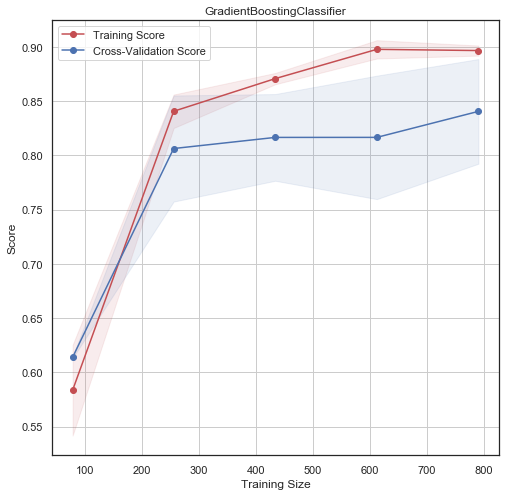

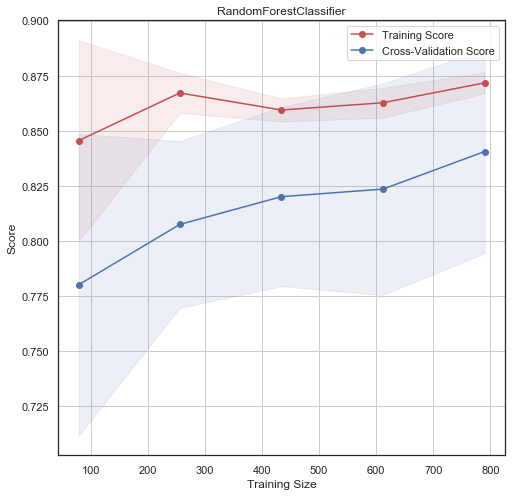

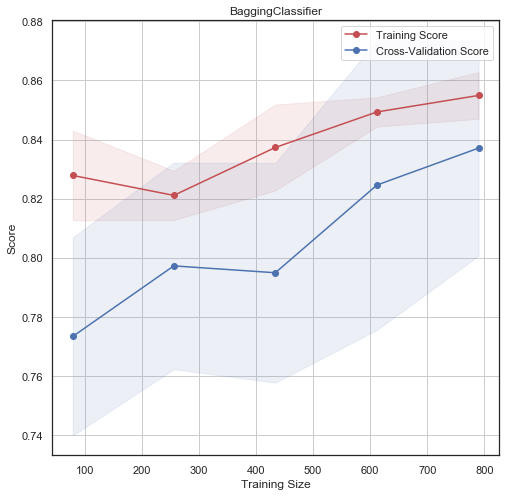

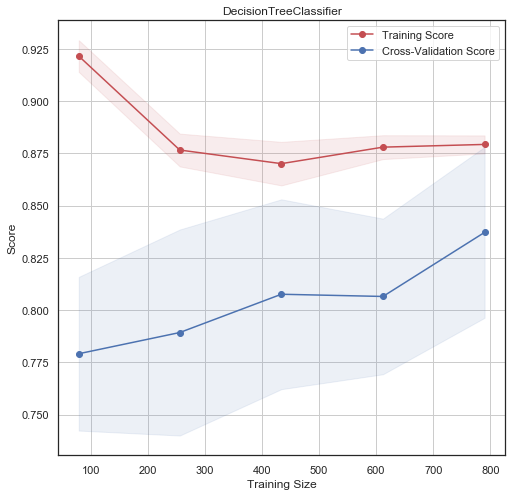

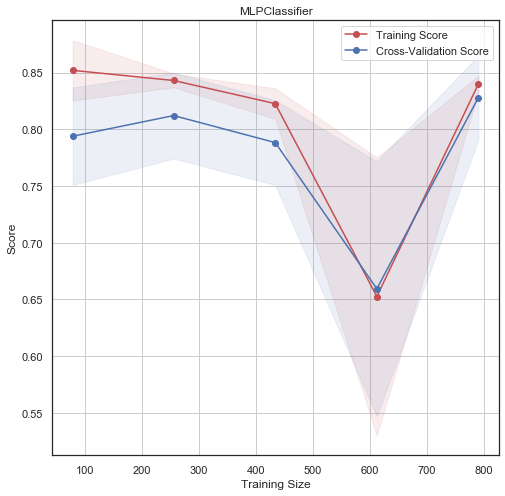

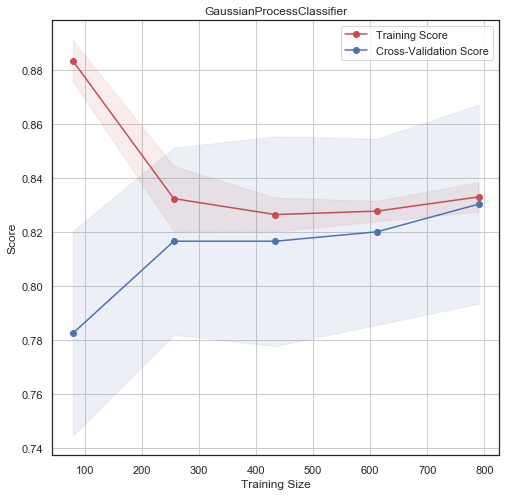

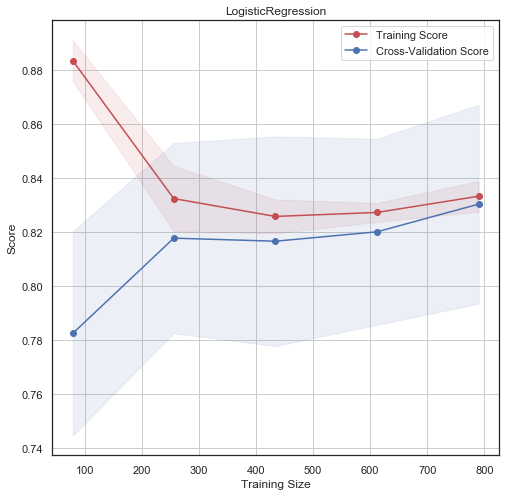

In [60]:
for i in range(len(best_algo)):
    g= learning_curve_plot(best_algo.loc[i,"Best_Estimators"], best_algo.loc[i,"Algorithm"], x_train, y_train, cv=k_fold)

(5.0, 0.0)

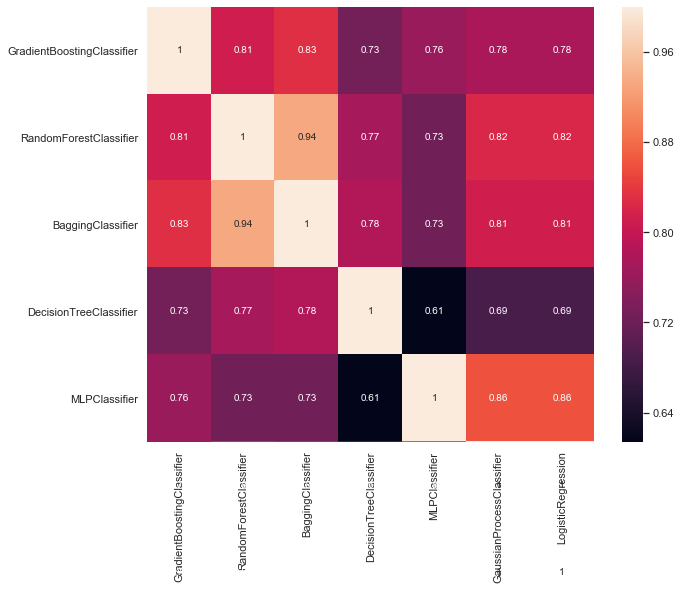

In [61]:
# Finding the relationship between diffrent classifiers on the basis of predicton data
predict_dict={}
for i in range(len(best_algo)):
    predict_dict[best_algo.loc[i,"Algorithm"]]= best_algo.loc[i,"Best_Estimators"].predict(test)

ensemble_results= pd.DataFrame(predict_dict)
plt.figure(figsize=(10,8))
g= sns.heatmap(ensemble_results.corr(),annot=True)
g.set_ylim(bottom + 0.5, top - 0.5)

In [62]:
# Making a list of tuples containing (algorithms, estimattor) to prepare it as a argument for voting classifier
estimator=[]
for i in range(len(best_algo)):
    estimator.append((best_algo.loc[i,"Algorithm"] , best_algo.loc[i,"Best_Estimators"]))

In [63]:
# Using voting classifier to predict the end result
vclf= VotingClassifier(estimators= estimator, voting= "soft", n_jobs=6 )
vclf.fit(x_train, y_train)
pred= vclf.predict(test)

In [64]:
# storing the result in ensemble_model_result.csv
pred= pred.astype(int)
output = pd.DataFrame({'PassengerId': passengerID, 'Survived': pred})
output.to_csv('ensemble_model_result.csv', index=False)

#### Got 0.78468 accuracy score on Kaggle